# Classical/Frequentist Statistical Inference: III

*S. R. Taylor (2024)*

Material in this lecture and notebook is based upon the "Maximum Likelihood and Applications in Astronomy" lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference" and "Histograms" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.
- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Contents
* [Hypothesis Testing](#one)
* [Comparing Distributions](#two)
* [Nonparametric Modeling & Histograms](#three)
---

## Hypothesis Testing <a class="anchor" id="one"></a>

A common problem in statistics is **hypothesis testing**, i.e., testing whether an observation or observations agree with a certain hypothesis. 

The simplest example is whether a measured value $x_i$ or an entire dataset $\{x_i\}$ are consistent with having been drawn from a Gaussian distribution, $\mathcal{N}(\mu,\sigma)$. In this example, $\mathcal{N}(\mu,\sigma)$ is the ***null hypothesis***, and we are trying to reject it in order to claim that we have measured some effect. 

A great example in astronomy is ***source detection*** in images that suffer from a substantial noise background (e.g., atmospheric fluctuations in optical images).
- Since the background fluctuates, we need the source flux in a given image resolution element (e.g., pixel) to be substantially larger than the background variation in order to give a robust detection.
- Here the null hypothesis is that the flux in each pixel is caused by background fluctuations, and if we can reject it then we can achieve source detection. 
- But note that *rejecting the null hypothesis is not the same as favoring the source hypothesis*! Our understanding of the background could be poor or incomplete, rendering our model of the null hypothesis similarly lacking.

In the image below (from the [photutils](https://photutils.readthedocs.io/en/stable/background.html) package) we have sources embedded in Gaussian image noise. 
- Ideally we would like to be able to find the real sources in here and assign a number that says how much they reject the null background hypothesis. 
- We would establish a threshold in these numbers above which we could accept sources, knowing that we might be falsely rejecting some real ones, but hopefully not accepting too many spurious noise sources.

![https://photutils.readthedocs.io/en/stable/_images/background-1.png](https://photutils.readthedocs.io/en/stable/_images/background-1.png)

Imagine we have data $\{x_i\}$. This could be signal strength in time-domain data, or pixel brightness in image data. Under an assumption about the null background distribution, $h_0(x)$, we can compute the probability that a data point would have a value as large or greater than that observed. This is called the ***$p$-value*** of the data:

$$ p_i = \int_{x_i}^\infty h_0(x)dx \equiv 1 - \int_{-\infty}^{x_i} h_0(x)dx = 1-H_0(x_i),$$

where $H_0(x)$ is the CDF (cumulative density function) of the null distribution.

In the image below, we show the distribution of a statistic $S$ under a null hypothesis $\mathcal{H}_\mathrm{null}$. The $p$-value of the observed statistic $S_\mathrm{obs}$ is shown graphically.

<!--<img src="figures/freq_pvalue.png" alt="" style="width: 500px;"/>-->

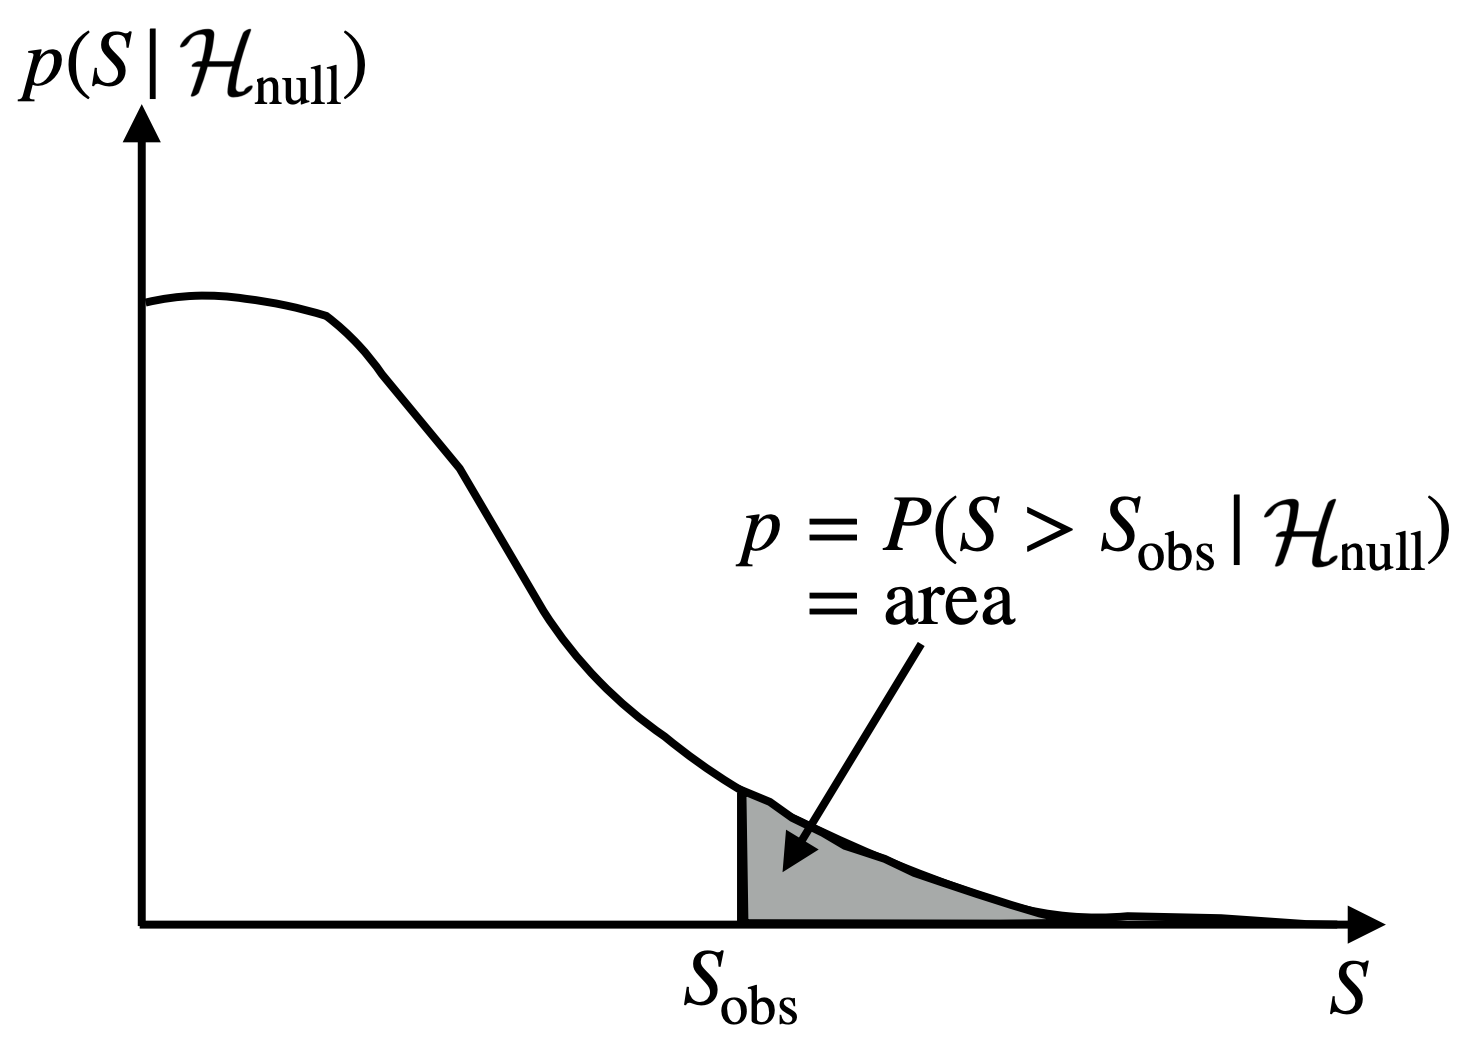

Typically, a threshold $p$-value is adopted, called the **significance, $\alpha$**. In a classification scheme, data would then reject the null hypothesis if $p_i\leq\alpha$. If $\alpha=0.05$, such data would reject the null hypothesis at the $0.05$ significance level. 

**NOTE**
- If we can't reject the null hypothesis then it doesn't mean the data belongs to the background. It could be that our sample is simply not large enough to detect an effect. 
- Rejecting the null hypothesis does not necessarily mean that we've proven a signal hypothesis. Our model of the null hypothesis could be bad, or there could be many other things we have not considered.
- There is ***alot*** of mis-use and abuse of p-values in the scientific literature. Take a quick scan of [this](https://fivethirtyeight.com/features/statisticians-found-one-thing-they-can-agree-on-its-time-to-stop-misusing-p-values/) and [this](https://www.wikiwand.com/en/Misuse_of_p-values) during class, and read thoroughly in your own time. 

**EXAMPLE**

Let's flip a coin 10 times. 
- Defining HEADS as a success event, use `scipy.stats` to define a binomial distribution over $10$ coin flips, where the intrinsic success probability is $0.5$. 
- Plot the probability mass function (the analog of the probability density function for discrete distributions).
- <font color='red'>If we get $8$ HEADS, what is the $p$-value with which we reject the hypothesis that the coin is fair?</font>

In [2]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats

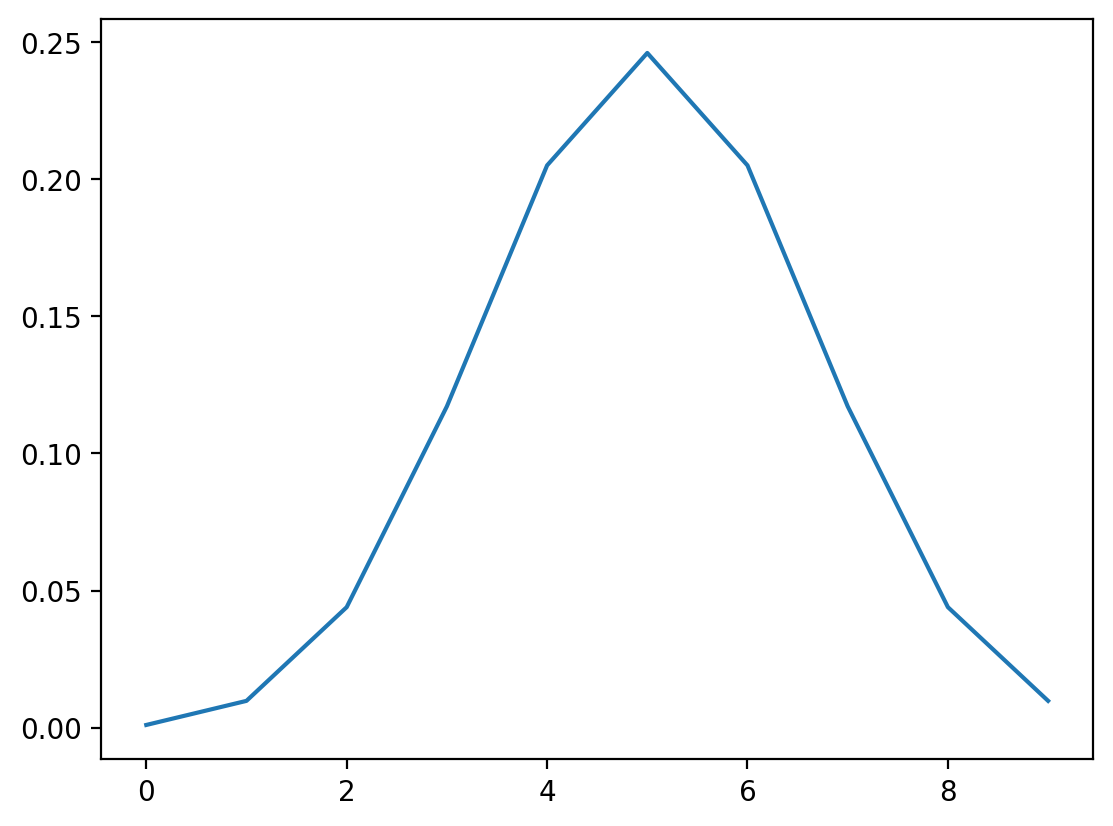

In [3]:
# Write your code to plot the binomial distribution in here.
bino = stats.binom(n=10,p=0.5)
xvals = np.arange(0,10) # use arange instead of linspace for discrete distributions
yvals = bino.pmf(xvals)
plt.plot(xvals, yvals);

In [4]:
# Write your code to compute the p-value of 8 heads in here.
pval8 = 1-bino.cdf(8)
print('pval:',pval8)
print('survival func:',bino.sf(8)) # check that 1 - cdf is the same as the survival function

pval: 0.0107421875
survival func: 0.0107421875


We look at our coin more shrewdly. In 20 flips, we get a result with $p$-value of $1$ in $10^3$ (i.e., $p = 0.001$). <font color='red'>How many HEADS did we get?</font> *Hint: check the properties of the `scipy.stats.binom` object for useful functions for this.*

In [5]:
# sf (survival function) = 1 - cdf
# sf given number of successes returns p-value
# inverse sf (isf) given p-value should return number of successes
numSuc = bino.isf(pval8)
print('Number of successes:',numSuc)
print('Yay!')

Number of successes: 8.0
Yay!


When making these kinds of classification decisions, we make two types of errors. These are quite literally described as **Type I** and **Type II** errors by *Neyman & Pearson*.

**TYPE I ERRORS**
- The null hypothesis is true, but incorrectly rejected.
- These are ***false positives*** (or false alarms).
- False positive probability is dictated by the significance level $\alpha$. 

**TYPE II ERRORS**
- The null hypothesis is false, but not rejected.
- These are ***false negatives*** (or false dismissals).
- False negatives probability is dictated by a variable called $\beta$, related to $(1-\beta)$, called the ***detection probability***.

Let's take a look at Fig 4.5 of Ivezic, v2. We have two Gaussian distributions; one describing the background noise and one describing the source. These distributions overlap, as they often do in real life.

<font color='red'>Execute the following cell. We'll discuss it more below.</font>

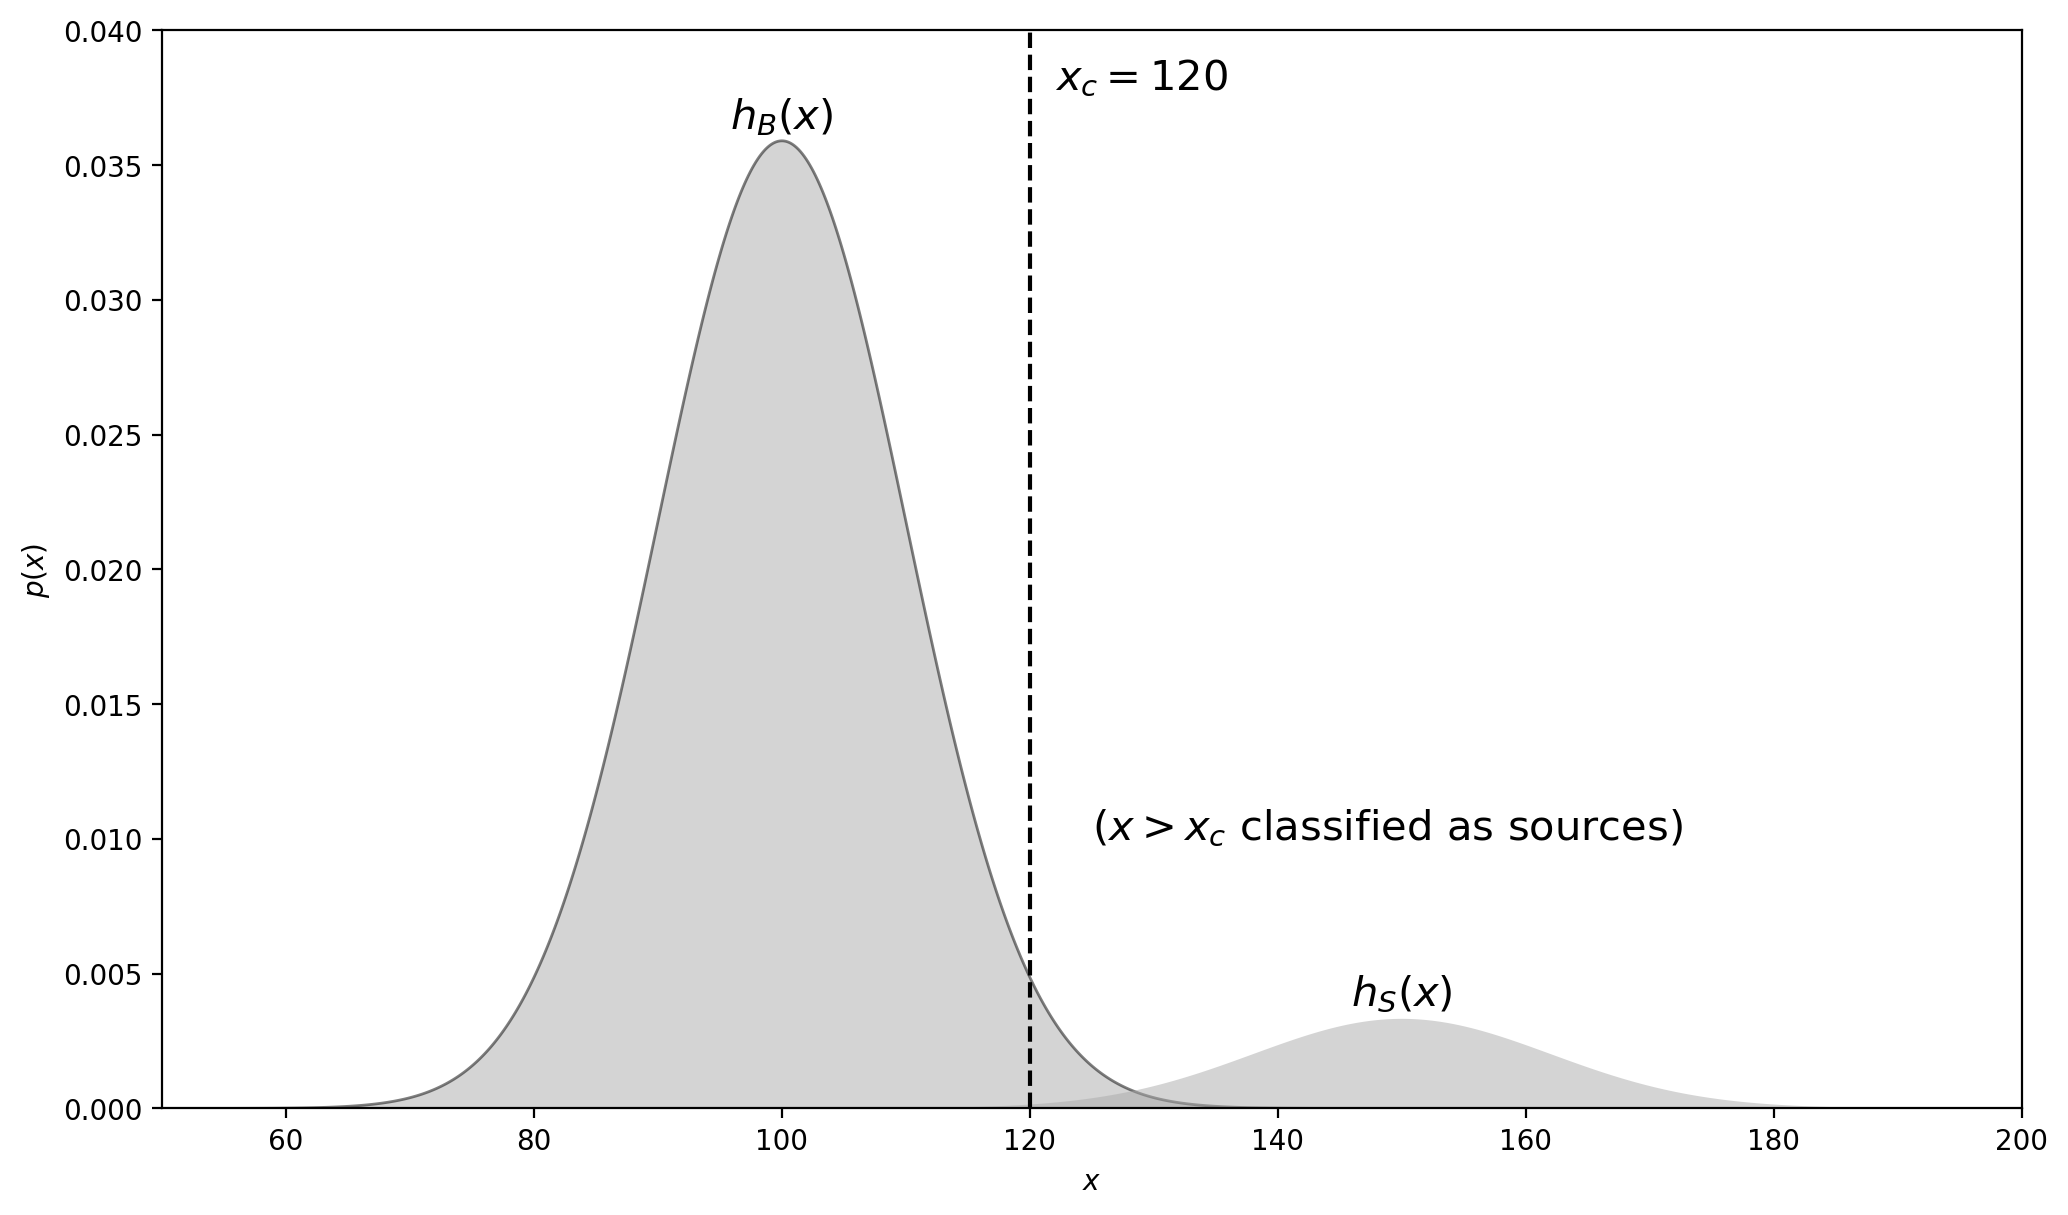

In [6]:
# %load ./scripts/fig_classification_example.py
"""
Example of classification
-------------------------
Figure 4.5.

An example of a simple classification problem between two Gaussian
distributions. Given a value of x, we need to assign that measurement to one
of the two distributions (background vs. source). The cut at xc = 120 leads
to very few Type II errors (i.e., false negatives: points from the distribution
hS with x < xc being classified as background), but this comes at the cost of
a significant number of Type I errors (i.e., false positives: points from the
distribution :math:`h_B` with x > xc being classified as sources).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#------------------------------------------------------------
# Generate and draw the curves
x = np.linspace(50, 200, 1000)
p1 = 0.9 * norm(100, 10).pdf(x)
p2 = 0.1 * norm(150, 12).pdf(x)

fig, ax = plt.subplots(figsize=(12, 7))
ax.fill(x, p1, ec='k', 
        fc='#AAAAAA', alpha=0.5)
ax.fill(x, p2, '-k', 
        fc='#AAAAAA', alpha=0.5)

ax.plot([120, 120], 
        [0.0, 0.04], '--k')

ax.text(100, 0.036, r'$h_B(x)$', ha='center', 
        va='bottom', fontsize=15)
ax.text(150, 0.0035, r'$h_S(x)$', ha='center', 
        va='bottom', fontsize=15)
ax.text(122, 0.039, r'$x_c=120$', ha='left', 
        va='top', fontsize=15)
ax.text(125, 0.01, 
        r'$(x > x_c\ {\rm classified\ as\ sources})$', 
        fontsize=15)

ax.set_xlim(50, 200)
ax.set_ylim(0, 0.04)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.show()

In this example, we have data $\{x_i\}$ drawn from an underlying distribution

$$ h(x) = (1-a)h_B(x) + ah_S(x)$$

where $h_B(x)=\mathcal{N}(\mu=100,\sigma=10)$ is the background distribution (normalized to unity), $h_S(x)=\mathcal{N}(\mu=150,\sigma=12)$ is the source distribution (normalized to unity), and $a$ is the relative normalization factor that accounts for background noise being $(1-a)/a$ more probable than sources.

- ***If we set a classificiation threshold at $x_c=120$, calculate the Type I error (false positive) probability, $\alpha$.***
- ***For the same $x_c$, calculate the Type II error (false negative) probability, $\beta$.***

In [15]:
hB = norm(100,10) # background distribution
hS = norm(150,12) # source distribution

# type 1 error probability is the upper end of the noise dist
    # null hypothesis is that the data is from noise, so take p value with noise dist
alpha_pval = 1 - hB.cdf(135) # cdf sums up to the val, so we need to get 1-cdf to get everything over 135
print('Alpha =', alpha_pval)

# type 2 error probability is the lower end of the signal dist
    # want lower end up to 135
beta_pval = hS.cdf(135)
print('Beta =',beta_pval)

Alpha = 0.0002326290790355401
Beta = 0.10564977366685535


<font color = 'lightblue'>  Since the p-value for alpha is lower we would reject the null hypothesis that the data point came from the noise distribution. The false negative being a 10% probability is not too low for it to be unreasonable that the data point is just a more unlikely signal. </font>

For a sample of size $N$ (containing background noise and sources), the **expected number of spurious sources (Type I / false positives)** is 

$$ n_\mathrm{spurious} = N(1-a)\alpha = N(1-a)\int_{x_c}^\infty h_B(x)dx$$ 

and the **expected number of missed sources (Type II / false negatives)** is

$$ n_\mathrm{missed} = Na\beta = Na\int_0^{x_c}h_S(x)dx.$$

The **total number of classified sources** (that is number of instances where we reject the null hypothesis) is

$$ n_\mathrm{source} = Na - n_\mathrm{missed} + n_\mathrm{spurious} = N[(1-\beta)a + (1-a)\alpha].$$

The **sample completeness** (or **detection probability**) is defined as

$$ \eta = \frac{Na - n_\mathrm{missed}}{Na} = 1-\int_0^{x_c}h_S(x)dx = 1-\beta$$

Finally, the **sample contamination** is

$$ \epsilon = \frac{n_\mathrm{spurious}}{n_\mathrm{source}}$$

where $(1-\epsilon)$ is sometimes called the **classification efficiency**.

## Comparing Distributions <a class="anchor" id="two"></a>

Hypothesis testing is strongly linked to the **comparison of distributions**. Common questions are whether two samples are drawn from the same distribution, or whether a sample is drawn from some known distribution (like a Gaussian).

Sometimes we may be only interested in the location parameter of some underlying distribution. For example, do two gravitational-wave detectors with different measurement uncertainties and local effects measure consistent masses of a merging system of black holes?

There is enormous variety in the nonparameteric and parameteric statistics to compare distributions, and we'll only look at a few. See the textbook and wider literature for further examples.

### Kolmogorov-Smirnov (KS) Test

By far the most popular nonparametric statistic to compare distribution is the KS test. We compute the empirical cdf $F(x)$ for two samples $\{x1_i\} = (1,\ldots,N_1)$ and $\{x2_i\} = (1,\ldots,N_2)$. *Recall that the empirical cdf can be calculated by sorting the samples and dividing by the sample size.*

The KS test is based on a statistic that measures the maximum difference in the cdfs of our two samples

$$ D = \mathrm{max}|F_1(x1) - F_2(x2)|$$

where $0\leq D\leq 1$. 

> The core idea is to know how often the value of $D$ computed from our data would arise by chance if both samples were drawn from the same distribution (which is our *null hypothesis* here). 

Amazingly, ***this does not depend on the underlying distribution we care about!*** Kolmogorov published the following result in 1933 and Smirnov published numerical tables in 1948. The probability of obtaining a value of $D$ larger than that observed in our data is

$$ Q_\mathrm{KS}(\lambda) = 2\sum_{k=1}^\infty (-1)^{k-1}\exp(-2k^2\lambda^2)$$

where 

$$\lambda = \left(0.12 + \sqrt{n_e} + \frac{0.11}{\sqrt{n_e}} \right)D $$

and the ***effective number of data points***, $n_e$, is

$$ n_e = \left( \frac{1}{N_1} + \frac{1}{N_2}\right)^{-1} = \frac{N_1 N_2}{N_1 + N_2}$$

If the probability that $D$ were drawn by chance is very small (low $p$-value) then we can reject the null hypothesis that the two samples were drawn from the same distribution.

For large $n_e$ we have $\lambda\approx\sqrt{n_e}D$. In fact, for $n_e>10$ we can bypass $Q_\mathrm{KS}$ entirely and compute the value of D that would correspond to a given significance level $\alpha$,

$$ D_\mathrm{KS} = \frac{C(\alpha)}{\sqrt{n_e}}$$

where $C(\alpha) = \sqrt{-\frac{1}{2}\ln(\alpha/2)}$. Some instructive significance levels are shown below (from [here](https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test)).

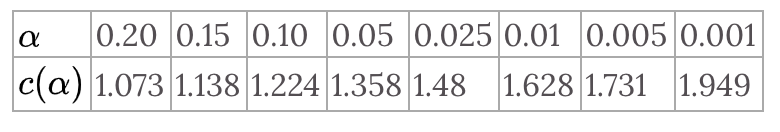

The KS test and variants can be accessed in the `scipy.stats` modules `kstest`, `ks_2samp`, and `ksone.` Let's look at a simple example for comparing a Gaussian sample to a Gaussian null hypothesis distribution.

In [16]:
# the kstest function is appropriate for this
np.random.seed(0)
x = np.random.normal(loc=0, scale=1, size=1000)
print(stats.kstest(x, 'norm'))

KstestResult(statistic=0.03737519429804048, pvalue=0.11930823166569182, statistic_location=0.47224715008784873, statistic_sign=1)


<font color='lightblue'> A typical value to compare the p-value to is 0.05, so since this p-value is greater than that, we can't reject the null hypothesis that the two distributions are the same. This makes sense, but I guess I'd expect a much larger statistic, if the statistic means probability that the distributions are the same. </font>

Let's now compare a $t$-distribution with $100$ degrees of freedom to a Gaussian distribution. <font color='red'>Complete the following cell. Discuss with your colleagues whether the result makes sense.</font>

In [17]:
np.random.seed(987654321)
print(stats.kstest(stats.t.rvs(df=100, size=100), 'norm'))

KstestResult(statistic=0.07201892916547126, pvalue=0.6505883498379312, statistic_location=1.4909975365781791, statistic_sign=-1)


<font color='lightblue'> The null hypothesis is that the two distributions are equal, so there should be a low p-val (reject null) when the two distributions are not the same, and a high p-val (can't reject null) when they are. So, this p-value is higher even though the distributions are different, probably because the dof are so high. </font>

<font color='red'>Try again and discuss for a $t$-process with only $3$ degrees of freedom.</font>

In [20]:
print(stats.kstest(stats.t.rvs(df=3,size=100),'norm'))

KstestResult(statistic=0.131016895759829, pvalue=0.058824941581447965, statistic_location=1.2319541590809242, statistic_sign=-1)


<font color='lightblue'> This p-value is lower, probably due to fewer dof. For this test we can feel better about rejecting the null. Also, not quite sure what the random seed functions are doing here. </font>

There are many other nonparametric tests, in particular the **Anderson-Darling test** to check whether a sample is consistent with having been drawn from a Gaussian distribution. We don't have time to do a deep dive here, but see the textbook for further details.

Read through and execute the following cell to perform the **KS test**, **Anderson-Darling test**, and the **Shapiro-Wilk test** applied to $10,000$ values drawn from a Gaussian distribution, and separately to a mixture of a Gaussian distribution. `scipy.stats` has many of the relevant functions. The print-out statements give statistic values and $p$-values.

______________________________________________________________________
  Kolmogorov-Smirnov test: D = 0.0076  p = 0.6
  Anderson-Darling test: A^2 = 0.29
    significance  | critical value 
    --------------|----------------
    0.58          | 15.0%
    0.66          | 10.0%
    0.79          | 5.0%
    0.92          | 2.5%
    1.09          | 1.0%
  Shapiro-Wilk test: W = 1 p = 0.57
  Z_1 = 0.2
  Z_2 = 1.0
______________________________________________________________________
  Kolmogorov-Smirnov test: D = 0.28  p = 0
  Anderson-Darling test: A^2 = 1.9e+02
    significance  | critical value 
    --------------|----------------
    0.58          | 15.0%
    0.66          | 10.0%
    0.79          | 5.0%
    0.92          | 2.5%
    1.09          | 1.0%
  Shapiro-Wilk test: W = 0.94 p = 0
  Z_1 = 32.2
  Z_2 = 2.5


/home/rothj1/anaconda3/envs/astr8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')
/home/rothj1/anaconda3/envs/astr8070/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


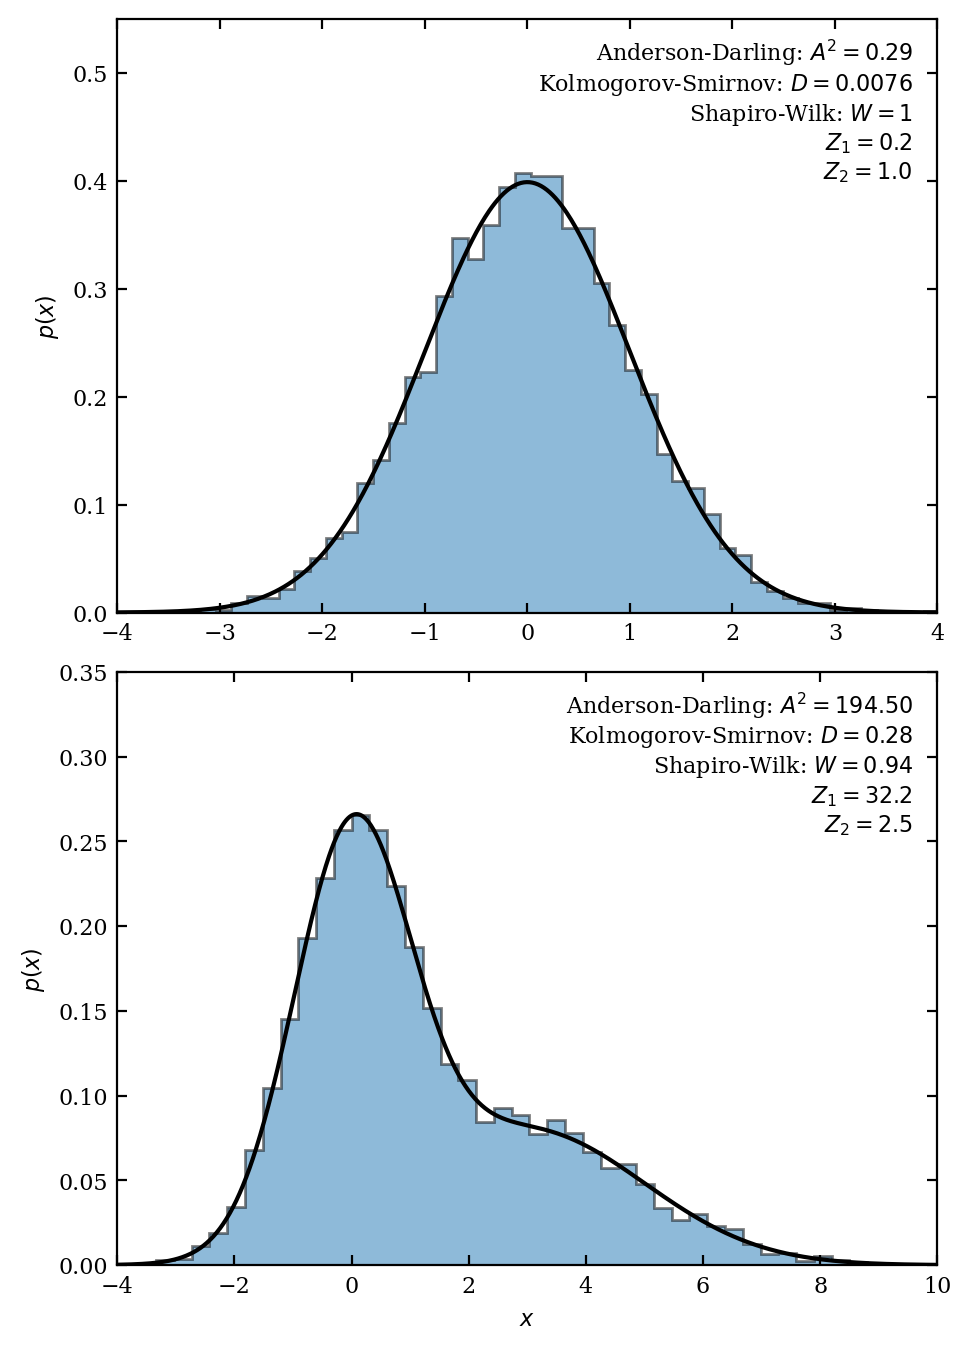

In [21]:
# %load /home/rothj1/Desktop/AstroStats/repos/astr_8070_s24/lectures/scripts/fig_anderson_darling.py
"""
Gaussianity Tests
-----------------
Figure 4.7.

The results of the Anderson-Darling test, the Kolmogorov-Smirnov test, and the
Shapiro-Wilk test when applied to a sample of 10,000 values drawn from a normal
distribution (upper panel) and from a combination of two Gaussian distributions
(lower panel).

The functions are available in the ``scipy`` package:

- The Anderson-Darling test (``scipy.stats.anderson``)
- The Kolmogorov-Smirnov test (``scipy.stats.kstest``)
- The Shapiro-Wilk test (``scipy.stats.shapiro``)
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

from astroML.stats import mean_sigma, median_sigmaG

# create some distributions
np.random.seed(1)
normal_vals = stats.norm(loc=0, scale=1).rvs(10000)
dual_vals = stats.norm(0, 1).rvs(10000)
dual_vals[:4000] = stats.norm(loc=3, scale=2).rvs(4000)

x = np.linspace(-4, 10, 1000)
normal_pdf = stats.norm(0, 1).pdf(x)
dual_pdf = 0.6 * stats.norm(0, 1).pdf(x) + 0.4 * stats.norm(3, 2).pdf(x)

vals = [normal_vals, dual_vals]
pdf = [normal_pdf, dual_pdf]
xlims = [(-4, 4), (-4, 10)]


#------------------------------------------------------------
# Compute the statistics and plot the results
fig = plt.figure(figsize=(5, 7))
fig.subplots_adjust(left=0.13, right=0.95,
                    bottom=0.06, top=0.95,
                    hspace=0.1)

for i in range(2):
    ax = fig.add_subplot(2, 1, 1 + i)  # 2 x 1 subplot

    # compute some statistics
    A2, sig, crit = stats.anderson(vals[i])
    D, pD = stats.kstest(vals[i], "norm")
    W, pW = stats.shapiro(vals[i])

    mu, sigma = mean_sigma(vals[i], ddof=1)
    median, sigmaG = median_sigmaG(vals[i])

    N = len(vals[i])
    Z1 = 1.3 * abs(mu - median) / sigma * np.sqrt(N)
    Z2 = 1.1 * abs(sigma / sigmaG - 1) * np.sqrt(N)

    print(70 * '_')
    print("  Kolmogorov-Smirnov test: D = %.2g  p = %.2g" % (D, pD))
    print("  Anderson-Darling test: A^2 = %.2g" % A2)
    print("    significance  | critical value ")
    print("    --------------|----------------")
    for j in range(len(sig)):
        print("    {0:.2f}          | {1:.1f}%".format(sig[j], crit[j]))
    print("  Shapiro-Wilk test: W = %.2g p = %.2g" % (W, pW))
    print("  Z_1 = %.1f" % Z1)
    print("  Z_2 = %.1f" % Z2)

    # plot a histogram
    ax.hist(vals[i], bins=50, density=True, 
            histtype='stepfilled', alpha=0.5)
    ax.plot(x, pdf[i], '-k')
    ax.set_xlim(xlims[i])

    # print information on the plot
    info = "Anderson-Darling: $A^2 = %.2f$\n" % A2
    info += "Kolmogorov-Smirnov: $D = %.2g$\n" % D
    info += "Shapiro-Wilk: $W = %.2g$\n" % W
    info += "$Z_1 = %.1f$\n$Z_2 = %.1f$" % (Z1, Z2)
    ax.text(0.97, 0.97, info,
            ha='right', va='top', transform=ax.transAxes)

    if i == 0:
        ax.set_ylim(0, 0.55)
    else:
        ax.set_ylim(0, 0.35)
        ax.set_xlabel('$x$')

    ax.set_ylabel('$p(x)$')

plt.show()

## Nonparametric Modeling & Histograms <a class="anchor" id="three"></a>

Imagine you have some one-dimensional ("univariate") data that you would like to try to understand.  Where by "understand" we mean "know the distribution in the measured space", i.e., you want to know the probability distribution function. Our constant friend is the histogram, and it's usually the first thing any of us do on new data. Simple, right? Not quite...

Let's work through some examples to see what problems we encounter and how we might overcome them.

In [22]:
# Execute this cell to generate a univariate data array, x
# this is the same data used in Ivezic, Figure 6.5

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 1000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

In the next few cells, make a normalized histogram of this data with 10 bins, 20 bins, and 100 bins. It starts off looking unimodal and Gaussian-ish, but clearly when more finely binned the data breaks up into several modes.

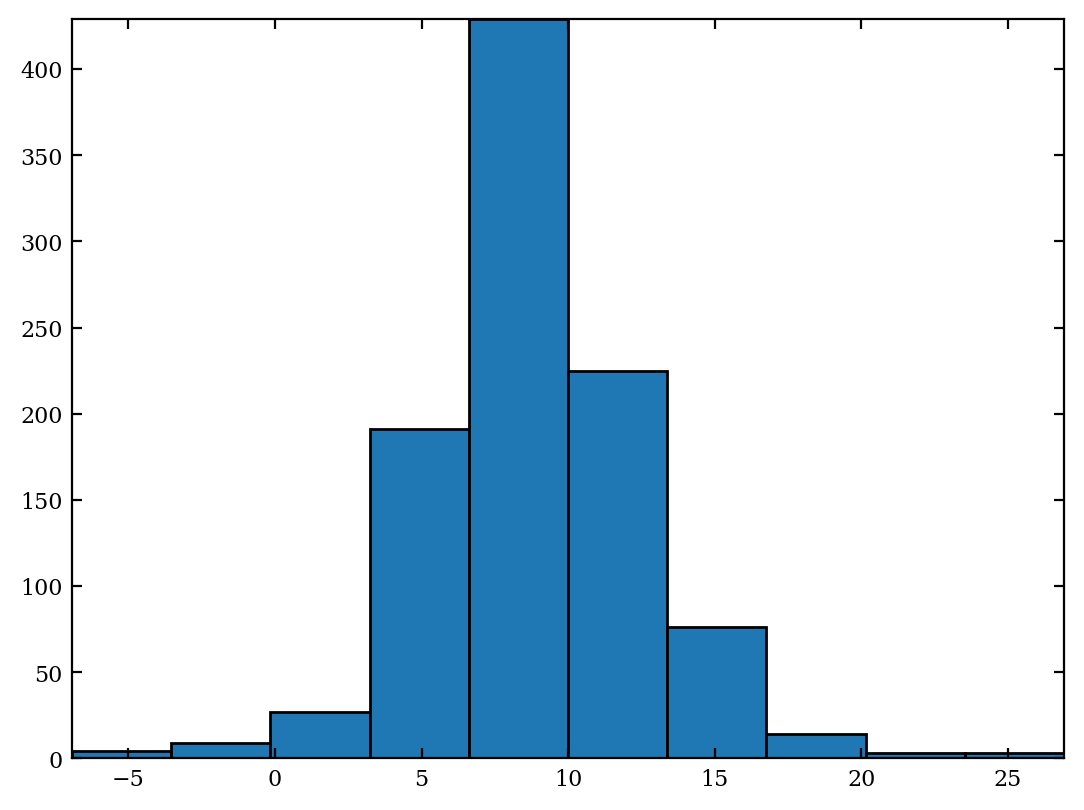

In [23]:
# 10 bins
plt.hist(x,bins=10); 

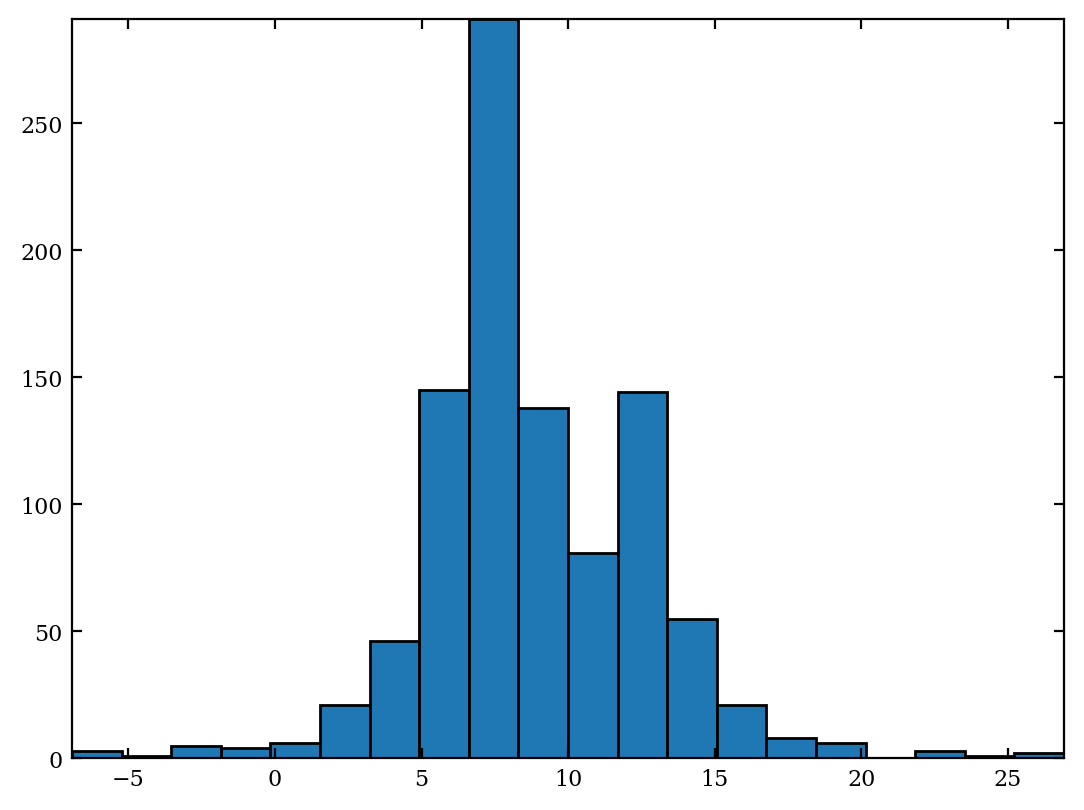

In [24]:
# 20 bins
plt.hist(x,bins=20); 

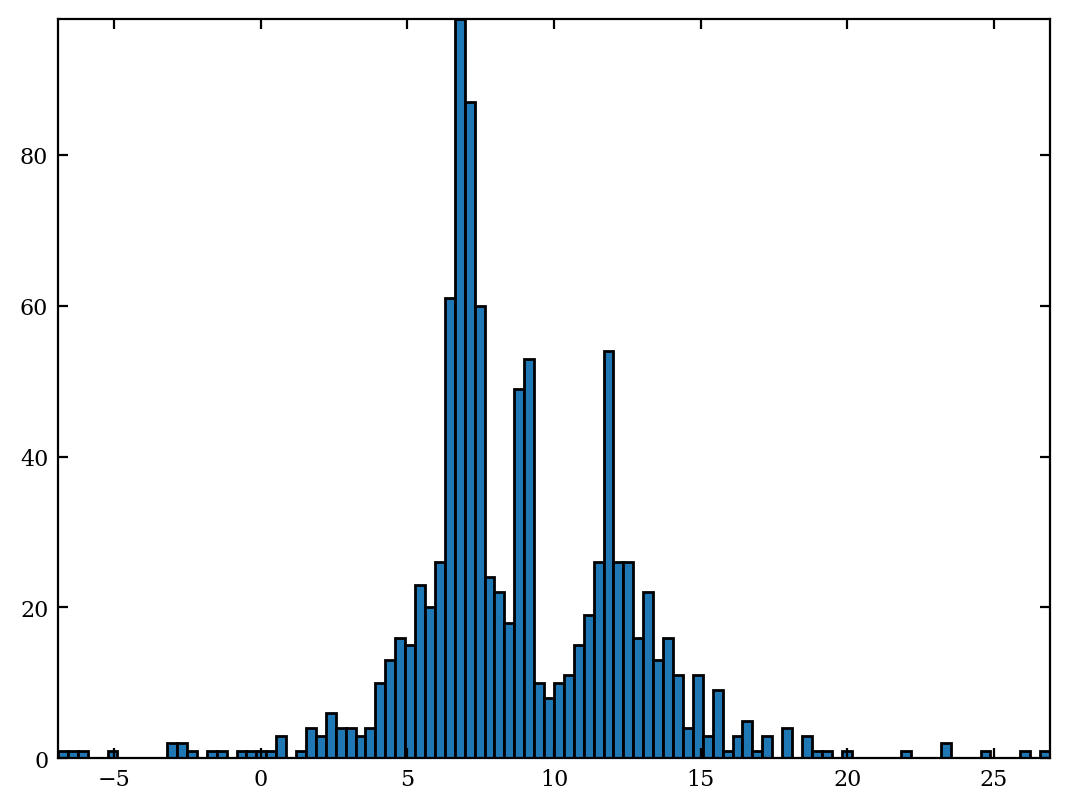

In [26]:
# 100 bins
plt.hist(x,bins=100); 

How would you characterize this distribution?  Could we reasonably think of it as a normal (Gaussian) distribution that we could characterize by some mean and standard deviation?  Maybe, but even just by looking at this plot we see that it wouldn't be a particularly good description of the data.

We find that small changes in parameters to the histogram function *significantly* change the PDF.  That's bad, because the underlying data clearly have **not** changed. One of the problems with histograms is that some bins end up with little (or no) data.  We can fix this by making **variable-width bin sizes** that have the ***same number of objects in each bin***.  How can we do this?

In [27]:
#Execute this cell
a = np.linspace(1,42,num=42)
print(a)
print(a[::2])
print(a[::3])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42.]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41.]
[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40.]


If you are familiar with slicing, then you know that `[::2]` and `[::3]` say to count by 2 and count by 3.  But that isn't what they really do.  They say to take every other index of the array or every 3rd index of the array.  So, if your array is sorted (like `a` is), then you could use this to instead define the number of values in a bin.  That is for any given value of `M`

    bins = np.append(np.sort(x)[::M], np.max(x))
    
would give bins with `M` objects in each bin.  

So if `M=3` and $x = [1,3,5,7,9,11,13,21,29,35]$ then $bins = [1 7 13 35]$.

*Note:* you need to add the maximum value to set the right edge of the last bin.  

Try it for `M=100` and `M=30` (100 and 30 objects in a bin).

In [28]:
bins100 = np.append(np.sort(x)[::100], np.max(x)) #Complete
bins30 = np.append(np.sort(x)[::30],np.max(x)) #Complete
print(len(bins100),len(bins30))

11 34


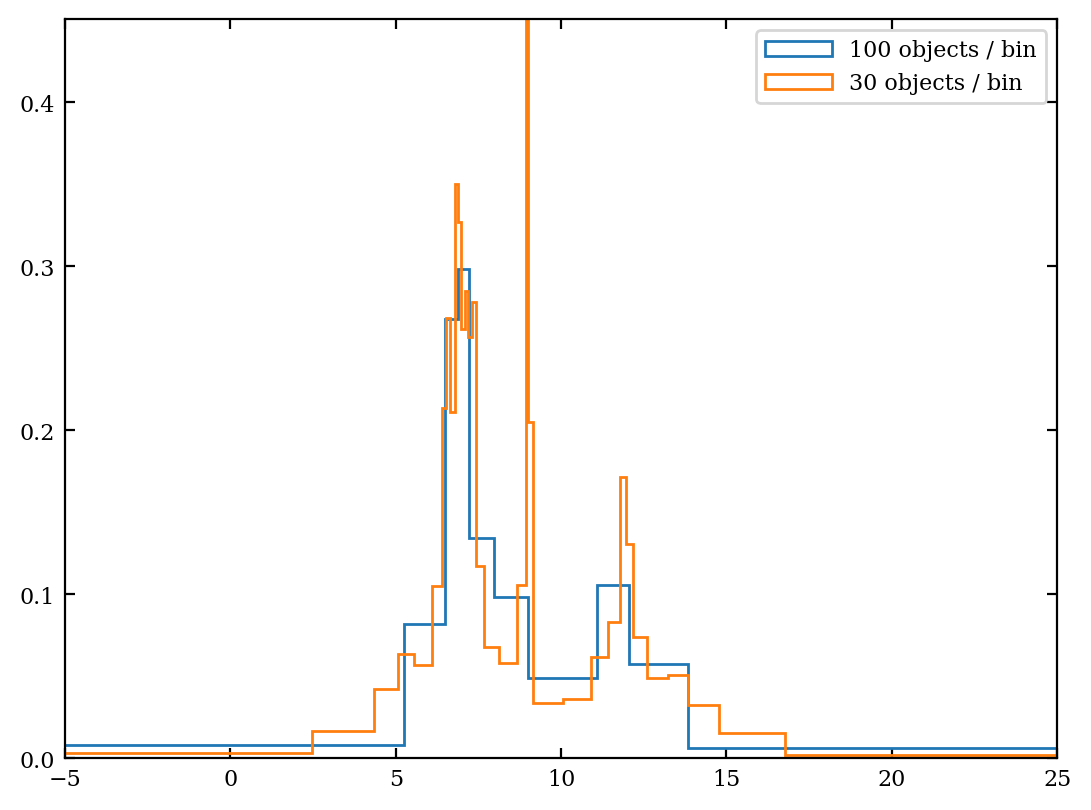

In [32]:
#Note that the underscores here are suppressing the array output
#so that we just see the plots
_ = plt.hist(x, bins=bins100, density=True, histtype="step",label='100 objects / bin') #Complete
_ = plt.hist(x,bins=bins30,density=True,histtype='step',label='30 objects / bin') #Complete
plt.xlim(-5,25)
plt.legend()

Again, this can look pretty different depending on what the number of objects you choose as the minimum for each bin and compared to the plots above.  And it looks a lot different from the plots above.

So, what is the "right" way to set the bin size? There is no "right" way, but there are some useful rules of thumb.

**"Scott's rule"** suggests that the optimal bin width is 

$$\Delta_b = \frac{3.5\sigma}{N^{1/3}}.$$

That's great, but what if we don't know the standard deviation, $\sigma$ (e.g., if the distribution isn't really Gaussian)?  

We can then instead used the **"Freedman-Diaconis rule"**: 

$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}.$$  

Let's try that. Remember that you can compute $\sigma_G$ using `astroML`.

In [33]:
from astroML import stats as astroMLstats
sigmaG2 = astroMLstats.sigmaG(x)
print(sigmaG2)

3.6731977984018402


<font color='red'>Now set the bin size accordingly</font>, using [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and plot.  Make sure that you don't throw away the last object in data set (append that maximum object to the end)! 

In [35]:
binsize = 2.7*sigmaG/(N**(1/3)) #Complete for Freedman-Diaconis Rule
print(binsize)
binsG = np.append(np.arange(start=x.min(), stop=x.max(), step=binsize) , x.max()) #Complete
print(len(binsG))
print(binsG)

0.5481792781503259
63
[-6.92142972 -6.37325044 -5.82507116 -5.27689189 -4.72871261 -4.18053333
 -3.63235405 -3.08417477 -2.53599549 -1.98781622 -1.43963694 -0.89145766
 -0.34327838  0.2049009   0.75308017  1.30125945  1.84943873  2.39761801
  2.94579729  3.49397657  4.04215584  4.59033512  5.1385144   5.68669368
  6.23487296  6.78305223  7.33123151  7.87941079  8.42759007  8.97576935
  9.52394862 10.0721279  10.62030718 11.16848646 11.71666574 12.26484502
 12.81302429 13.36120357 13.90938285 14.45756213 15.00574141 15.55392068
 16.10209996 16.65027924 17.19845852 17.7466378  18.29481708 18.84299635
 19.39117563 19.93935491 20.48753419 21.03571347 21.58389274 22.13207202
 22.6802513  23.22843058 23.77660986 24.32478913 24.87296841 25.42114769
 25.96932697 26.51750625 26.91818424]


(-5.0, 25.0)

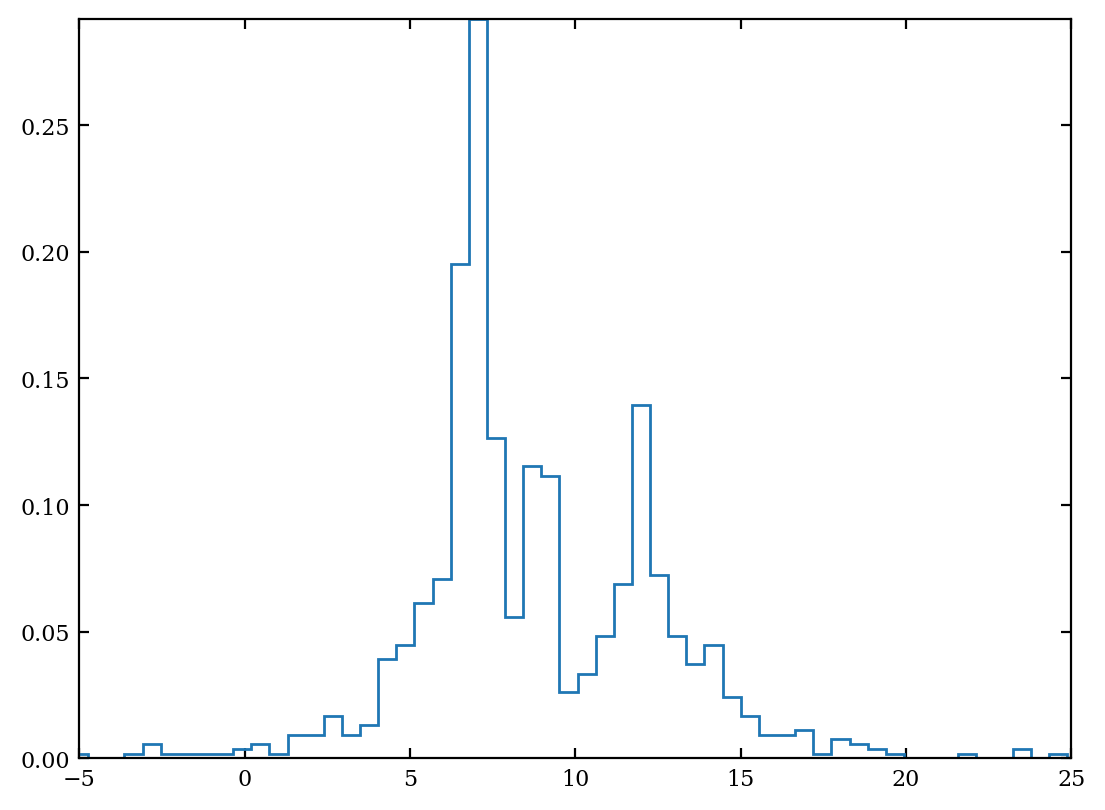

In [36]:
_ = plt.hist(x,bins=binsG,density=True,histtype='step') #Complete   
plt.xlim(-5,25)

Did you find that tedious? Me too. Try the following shortcut.

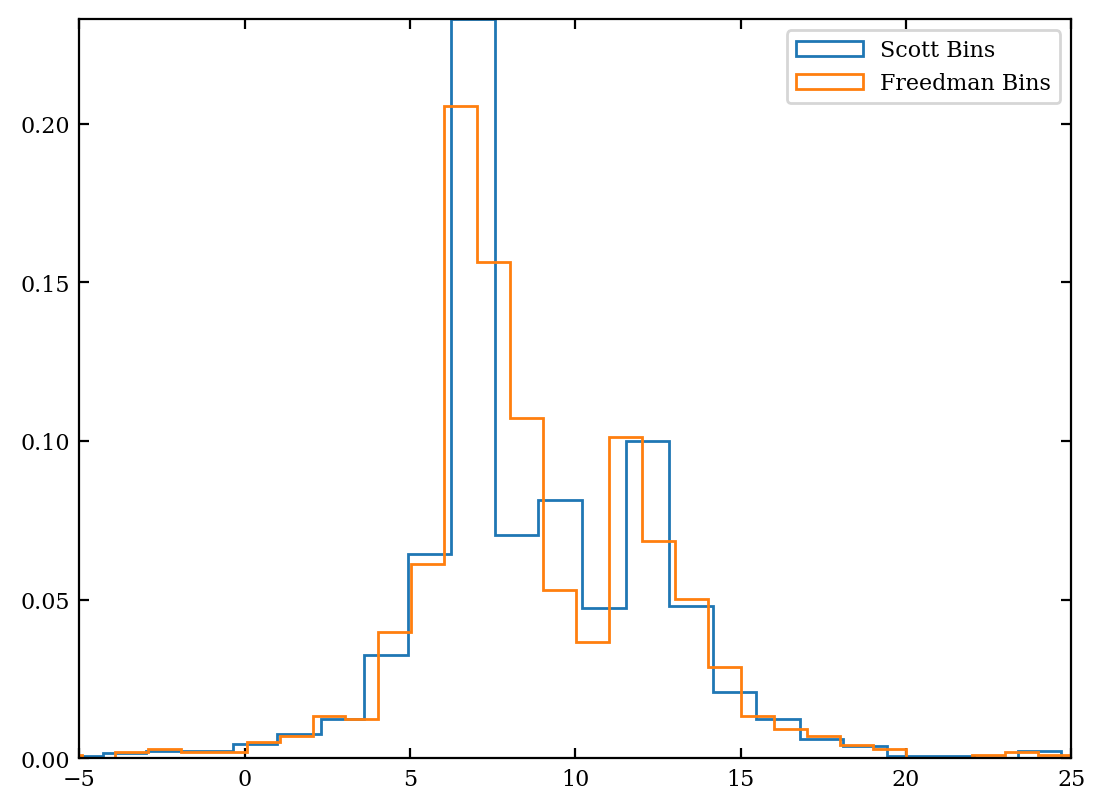

In [39]:
from astropy.visualization.hist import hist as fancyhist
_ = fancyhist(x, bins="scott", histtype="step",density=True,label='Scott Bins')
_ = fancyhist(x, bins="freedman", histtype="step",density=True,label='Freedman Bins')
plt.xlim(-5,25)
plt.legend()

Note that even those don't yield quite the same results!  But we can do better!

An obvious thing to do is to simply show all of the data.

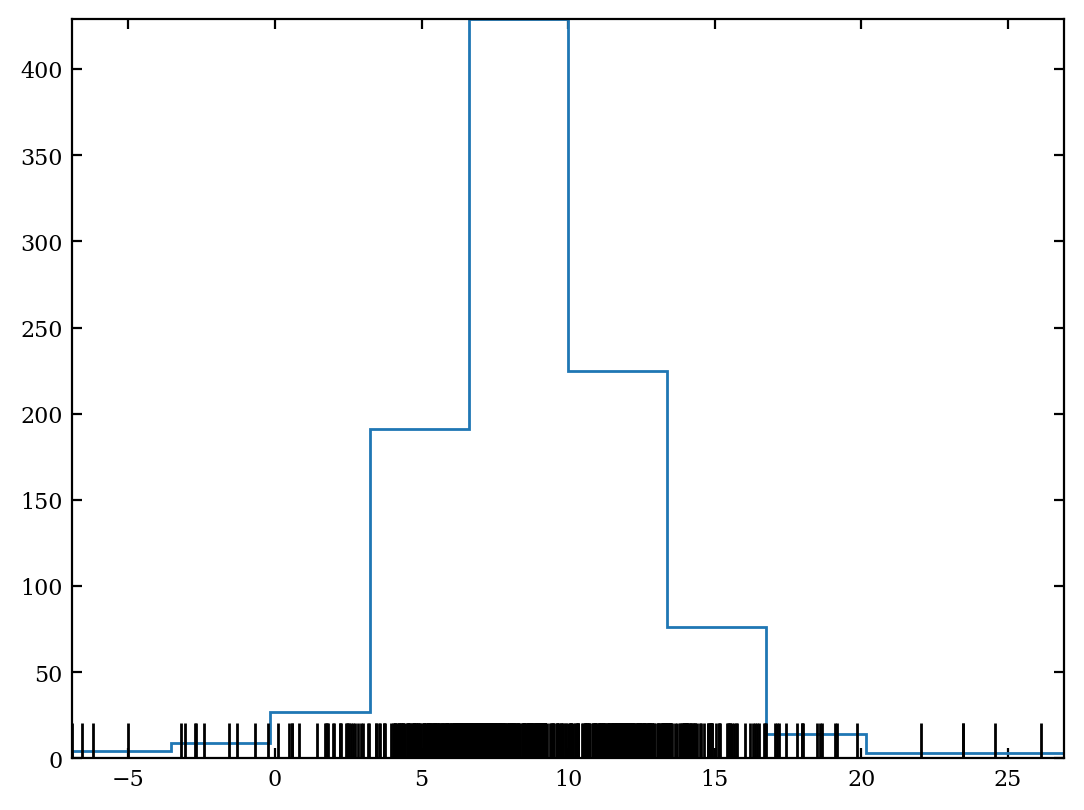

In [40]:
# execute this cell
plt.hist(x,histtype="step")
plt.plot(x, 0*x, '|', color='k', markersize=25) #Note markersize is (annoyingly) in *points*

This is called a **rug plot** and now we have a better idea of where most of the data and where the gaps really are (as opposed to where the binning makes them *appear* to be).  However, the markers are all piled up, so we have lost all sense of the relative numbers of objects.  Are there ~10 at x=5 or could there be 100?

This is where **[Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE)** comes in:
- In short the idea here is to represent each data point not as a delta function, but rather as a distribution (e.g., a Gaussian).  
- Those individual distributions ("kernels") are summed up to produce the PDF.  
- One of the advantages of this is that it combines the best of 
    1. the histogram (tells us the relative height of the distribution) 
    2. the rug plot (centers the data points at the actual location of the data instead of within some arbitrary bin)

Just about any distribution can be used as the kernel, but the most common are a **Gaussian kernel** and an **Epanechnikov kernel**.  One downside of the Gaussian kernel is that the tails are technically infinite in extent.  So each point has some finite probability of being *everywhere*.  The Epanechnikov kernel has truncated wings.  

One still has the problem of deciding the width of the kernel (e.g., for the Gaussian the *"mean"* is fixed at the value of the point, but how wide should you make the Gaussian?). For now, we'll just play with the widths by hand to see what might work best.  N.B. the widths of the kernel distribution are referred to as **"bandwidth"**.

In [41]:
# execute this cell to load the KDE module
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(x.min(),x.max(),1000)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Before we try the Gaussian and Epanechnikov kernels, let's first start with a tophat using `kernel = "tophat"`, which will produce a plot much like the rug plot.

Start with `bandwidth=0.01`.  See what happens when you adjust this.

Funky!


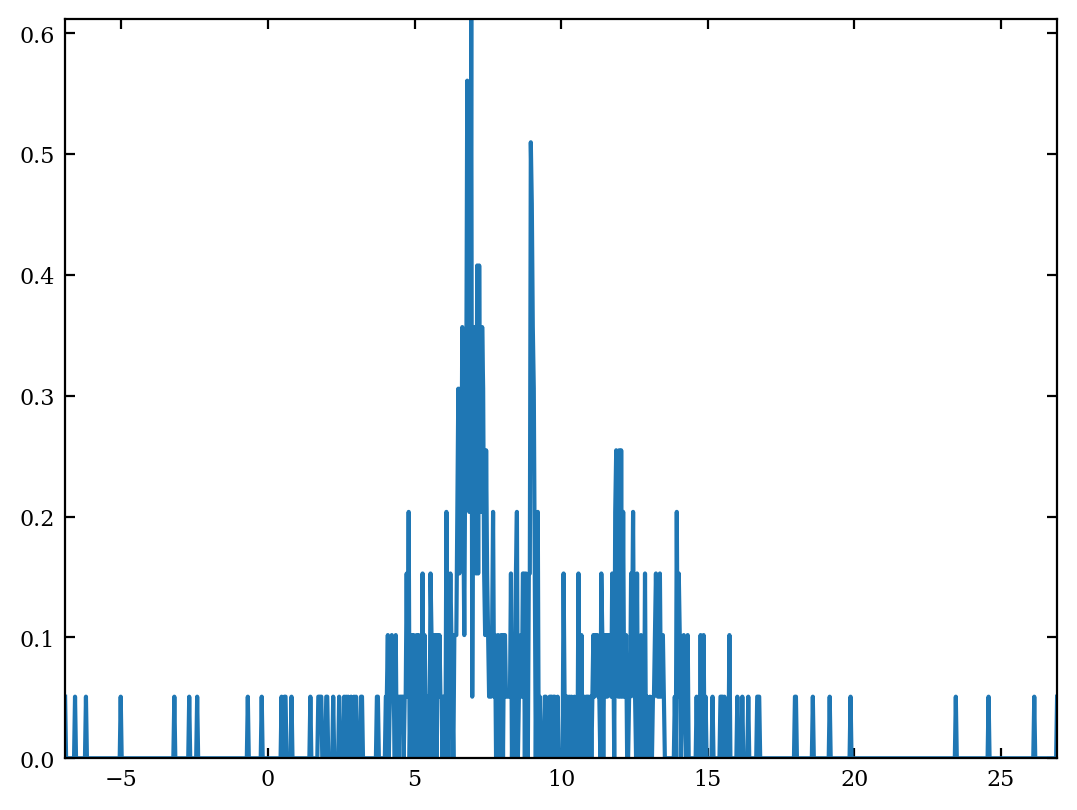

In [44]:
PDFtophat = kde_sklearn(x,bandwidth=0.01,kernel='tophat') #Complete
plt.plot(xgrid,PDFtophat) #Complete
print('Funky!')

The defaults give a result that is essentially what you would get if you made a histogram with a really large number of bins.

Now let's compare what happens when we adjust the bandwidth (which is just the width of the kernel function).  Try 
`bandwidth=0.1` and `bandwidth=0.5`.

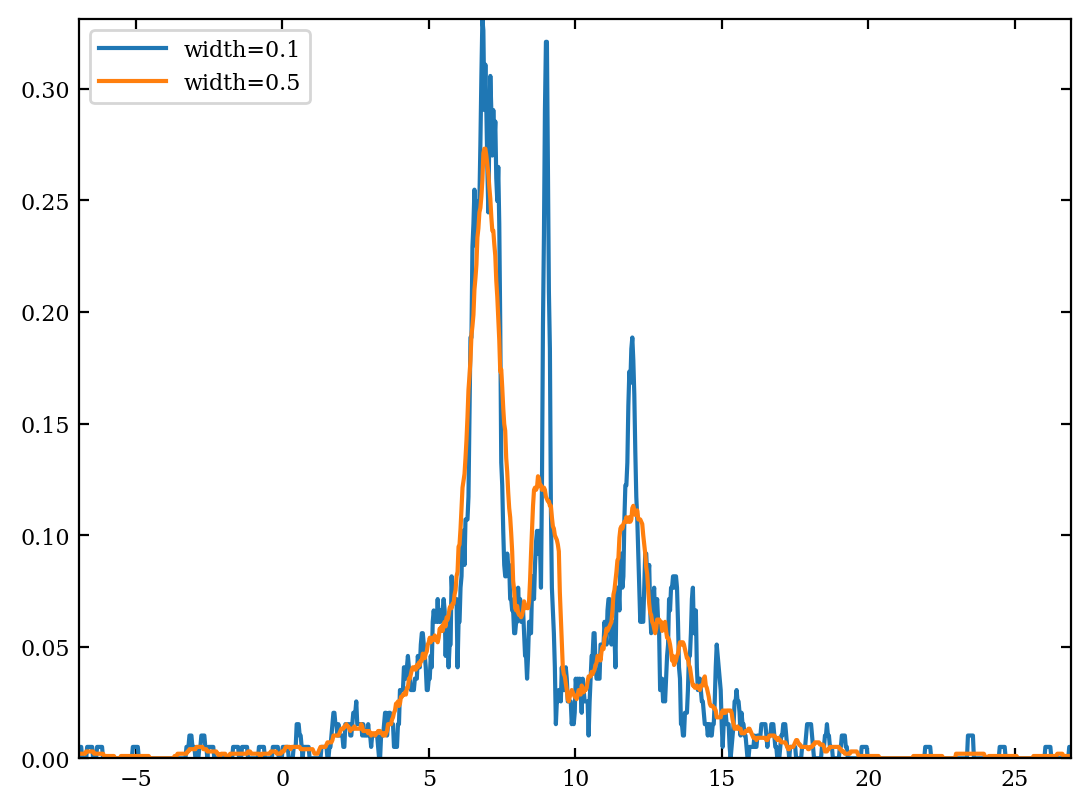

In [45]:
PDFtophat1 = kde_sklearn(x,bandwidth=0.1,kernel='tophat') #Complete
plt.plot(xgrid,PDFtophat1,label='width=0.1') #Complete

PDFtophat5 = kde_sklearn(x,bandwidth=0.5,kernel='tophat') #Complete
plt.plot(xgrid,PDFtophat5,label='width=0.5') #Complete
    
plt.legend(loc="upper left")

<font color='lightblue'> Gets smoother looking as bandwidth increases? </font>

Now let's see what we get with the Gaussian `kernel="gaussian"` and Epanechnikov `kernel="epanechnikov"` kernels.  <font color='red'>Play with the bandwidths until you get something that looks reasonable</font> (and roughly matches) for the two kernels.  They need not be the same.

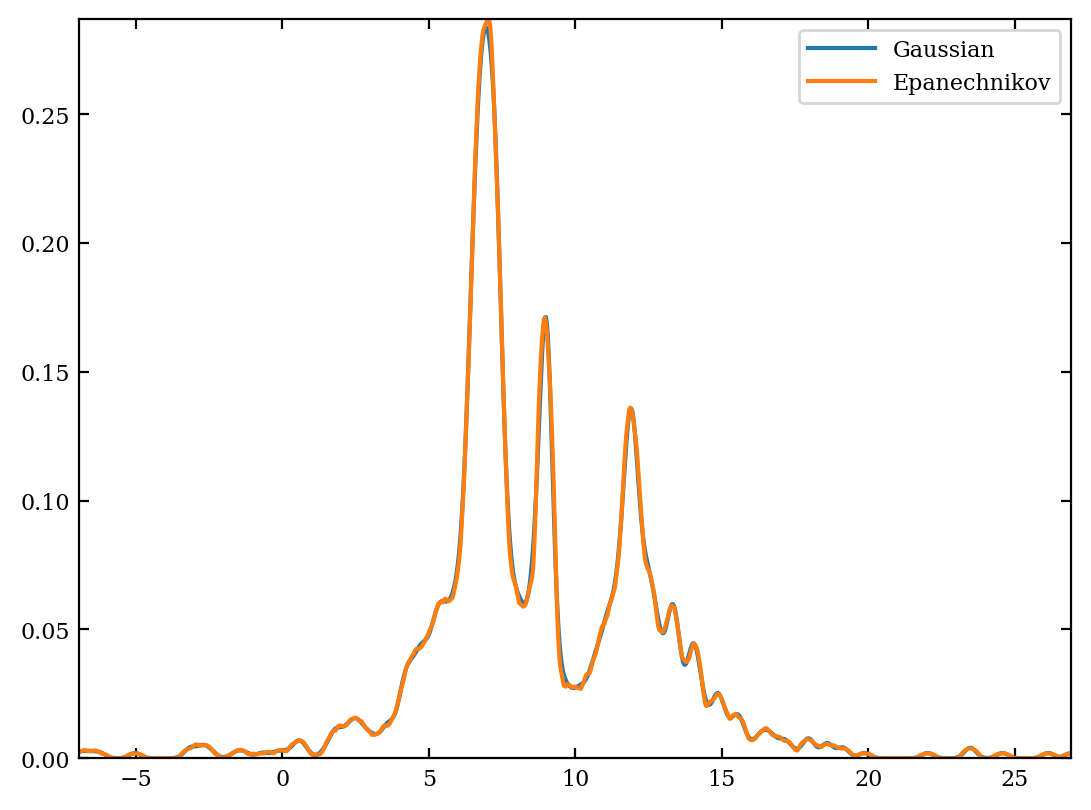

In [56]:
PDFgaussian = kde_sklearn(x,bandwidth=0.2,kernel="gaussian") #Complete 
PDFepanechnikov = kde_sklearn(x,bandwidth=0.4,kernel="epanechnikov") #Complete

plt.plot(xgrid,PDFgaussian,label="Gaussian") #Complete
plt.plot(xgrid,PDFepanechnikov,label='Epanechnikov') #Complete
plt.legend(loc='upper right') #Complete

This is pretty different from the histogram that we started out with, isn't it?

**HISTOGRAMS TAKE-AWAY MESSAGE:** 

Making a histogram is the first-cut we make of data, and it's certainly one of the most sensible things to try to get a feel for the data. But we can't just do it without thinking. We need to explore bin sizes and KDE smoothing bandwidths to tease out the structure in the distributions, and overcome any finite sample effects in bins by potentially having variable bin widths.

Finally, the normalized bin height of a histogram can simply be understood as

$$ f_k = \frac{n_k}{\Delta_b N}$$

where $k$ indexes the bin, $n_k$ is the occupancy number of the bin, $\Delta_b$ is the bin width, and $N$ is the total sample size. If we want to assign **uncertainties** to each bin height (not often done, but its good practice) then we can quote

$$ \sigma_k = \frac{\sqrt{n_k}}{\Delta_b N}$$